<a href="https://colab.research.google.com/github/chandank21/Electrical-Household-Load-Forecasting/blob/main/Load_Forecasting_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from  sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from keras.models import load_model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
def load_data(file_dir):
    data = pd.read_csv(file_dir,sep=';',
                    header=0,low_memory=False,
                    infer_datetime_format=True,
                    parse_dates={'datetime':[0,1]},
                    index_col=['datetime'])
    return data

def clean_data(data):
  data.replace('?',np.NaN,inplace=True)
  data = data.fillna(method='bfill')
  data = data.astype('float32')
  return data

def remove_outlier(data):
  data_reindexed = data.reset_index(drop=False)
  deviation = (data_reindexed.Global_intensity.values*2) - data_reindexed.Global_intensity.shift(1) - data_reindexed.Global_intensity.shift(-1)
  deviation_index = data_reindexed[abs(deviation) > 10].index

  for index in deviation_index:
    for cols in data.columns:
        data_reindexed.loc[index,cols] = np.mean((data_reindexed.loc[index-1,cols],data_reindexed.loc[index,cols],data_reindexed.loc[index+1,cols]))

  # adding original index...
  data = data_reindexed.set_index(data_reindexed['datetime'])
  data = data.drop(['datetime'],axis=1)
  return data

def scaling_data(data):
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(data)
  return scaled,scaler

def series_to_supervised(df_as_np,n_lags,n_out=1):
  X,y = [],[]
  for i in range(len(df_as_np)-n_lags):
    row = [ a for a in df_as_np[i:i+n_lags]]
    X.append(row)
    label = df_as_np[i+n_lags:i+n_lags+n_out,0]
    y.append(label)
  return np.array(X), np.array(y)

In [16]:
dataset = load_data(r'/content/drive/MyDrive/datasets/household_power_consumption.txt')

In [ ]:
dataset2 = 

In [46]:
# Useful columns...
cols=['Global_active_power', 'Global_reactive_power', 'Global_intensity']

# useful data..
dataset = dataset[cols]

#cleaning data and filling mising values..
clean_data = clean_data(dataset)

# removing outliers....
outlier_removed_data = remove_outlier(clean_data)

# resampling data based on hour...
data_hourly = outlier_removed_data.resample('H').mean()

# scaling data based on minmaxscaler or standard scaler...
data_as_np,scaler = scaling_data(data_hourly)

# no pf back step...
n_lags=120
n_out=1
 # converting data into deep neural network format...
input,target = series_to_supervised(data_as_np,n_lags,n_out)
input , target = input[500:],target[500:]
train_input = input[:23000]
test_input = input[26000:]
validation_input = input[23000:26000]
train_target = target[:23000]
test_target = target[26000:]
validation_target = target[23000:26000]
train_input.shape,test_input.shape,train_target.shape,test_target.shape

((23000, 120, 3), (7969, 120, 3), (23000, 1), (7969, 1))

(array([1.6923e+04, 7.4050e+03, 5.6410e+03, 2.6570e+03, 1.2100e+03,
        4.7800e+02, 1.8200e+02, 6.8000e+01, 1.6000e+01, 9.0000e+00]),
 array([ 0.50333333,  3.2913332 ,  6.0793333 ,  8.867333  , 11.6553335 ,
        14.443334  , 17.231333  , 20.019333  , 22.807333  , 25.595333  ,
        28.383333  ], dtype=float32),
 <a list of 10 Patch objects>)

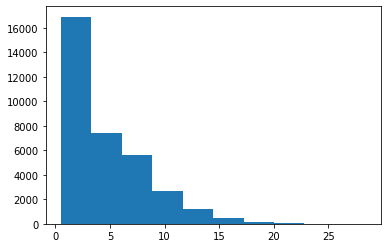

In [158]:
plt.hist(dataset.Global_intensity.values)

(array([1.226018e+06, 6.201120e+05, 1.430160e+05, 6.052300e+04,
        1.769500e+04, 6.005000e+03, 1.440000e+03, 3.750000e+02,
        6.800000e+01, 7.000000e+00]),
 array([ 0.2     ,  5.02    ,  9.84    , 14.660001, 19.480001, 24.300001,
        29.12    , 33.940002, 38.760002, 43.58    , 48.4     ],
       dtype=float32),
 <a list of 10 Patch objects>)

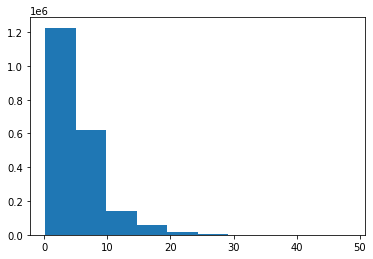

In [50]:
import matplotlib.pyplot as plt
plt.hist(outlier_removed_data.Global_intensity.values)

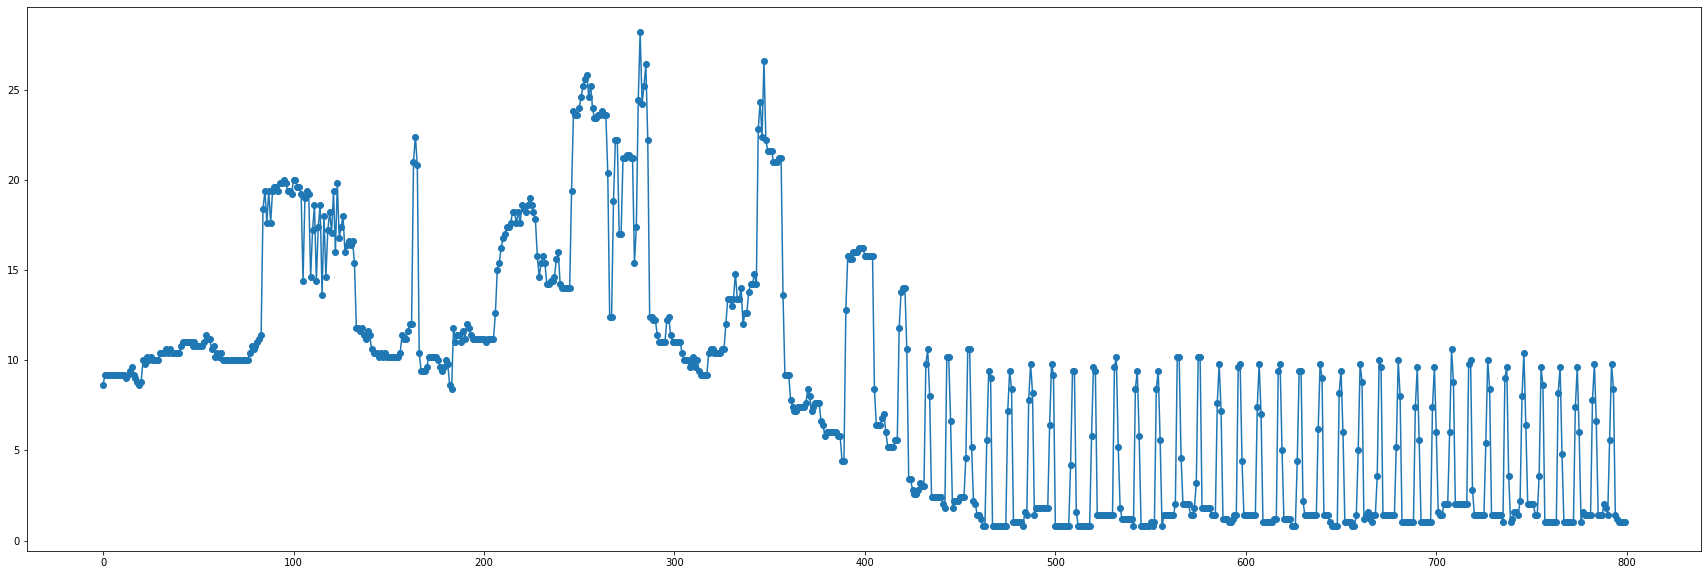

In [55]:
plt.figure(figsize=(30,10))
plt.plot(outlier_removed_data.Global_intensity.values[20000:20800],marker='o')

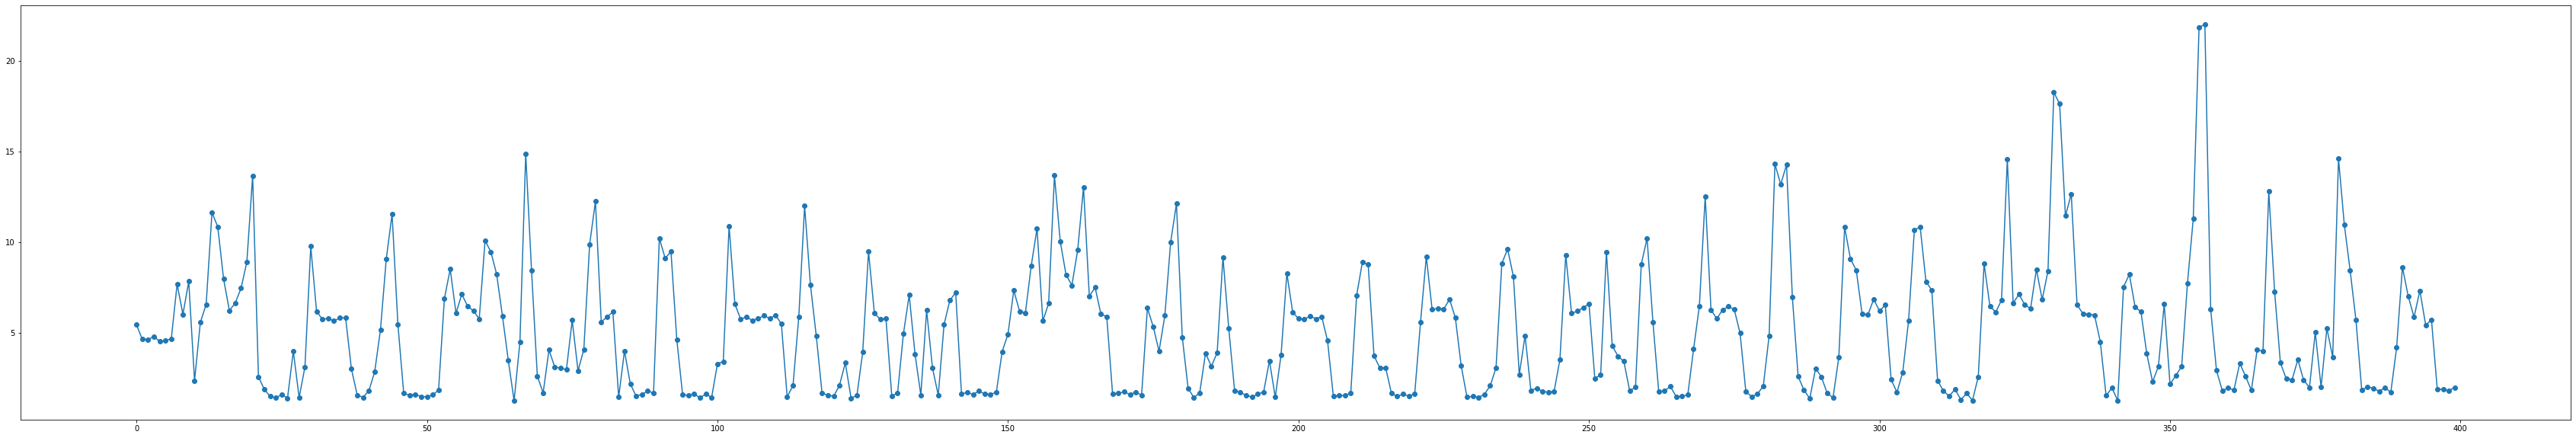

In [56]:
plt.figure(figsize=(60,10))
plt.plot(data_hourly.Global_intensity.values[20000:20400],marker='o')

In [ ]:
#date_index=new_data.index.to_series()
#new_data['year']=date_index.dt.year
#new_data['month']=date_index.dt.month
#new_data['day_of_week']=date_index.dt.dayofweek
#new_data['hour']=date_index.dt.hour
#new_data = new_data.reset_index(drop=True)

#new_data['hour_cos'] = np.cos(2 * np.pi * new_data['hour'] / 24)
#new_data['hour_sin'] = np.sin(2 * np.pi * new_data['hour'] / 24)

#new_data['Global_active_power'] = 1000*new_data['Global_active_power']

#new_data.drop(labels=['hour'],axis=1,inplace=True)
#new_data.drop(labels=['Global_active_power'],axis=1,inplace=True)

In [58]:
data_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34589 entries, 2006-12-16 17:00:00 to 2010-11-26 21:00:00
Freq: H
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    34589 non-null  float32
 1   Global_reactive_power  34589 non-null  float32
 2   Global_intensity       34589 non-null  float32
dtypes: float32(3)
memory usage: 675.6 KB


# Models...

**model1..LSTM**

In [59]:
def create_model(input_shape):
  model = Sequential()
  # input layer...
  model.add(LSTM(100,activation='relu',input_shape = input_shape))
  model.add(Dropout(0.2))
  model.add(Dense(8, 'relu'))
  #output layer...
  model.add(Dense(1, 'linear'))

  model.summary()
  return model

In [60]:
input_shape = (n_lags, len(cols))
model =create_model(input_shape)
cp1 = ModelCheckpoint('model1/', save_best_only=True)

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

model_summary = model.fit(train_input, train_target, validation_data=(test_input, test_target), epochs=20, batch_size=70, callbacks=[cp1])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               41600     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 8)                 808       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 42,417
Trainable params: 42,417
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
329/329 [==============================] - ETA: 0s - loss: 0.0207 - root_mean_squared_error: 0.1440INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 54s 155ms/step - loss: 0.0207 - root_mean_squared_error: 0.1440 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1079
Epoch 2/20
329/329 [==============================] - ETA: 0s - loss: 0.0154 - root_mean_squared_error: 0.1242INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 51s 156ms/step - loss: 0.0154 - root_mean_squared_error: 0.1242 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1023
Epoch 3/20
329/329 [==============================] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.1177INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 50s 153ms/step - loss: 0.0139 - root_mean_squared_error: 0.1177 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0955
Epoch 4/20
329/329 [==============================] - ETA: 0s - loss: 0.0125 - root_mean_squared_error: 0.1119INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 51s 156ms/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0910
Epoch 5/20
329/329 [==============================] - ETA: 0s - loss: 0.0116 - root_mean_squared_error: 0.1079INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 50s 152ms/step - loss: 0.0116 - root_mean_squared_error: 0.1079 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894
Epoch 6/20
329/329 [==============================] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.1056INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 50s 152ms/step - loss: 0.0111 - root_mean_squared_error: 0.1056 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0879
Epoch 7/20
329/329 [==============================] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.1044INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 50s 153ms/step - loss: 0.0109 - root_mean_squared_error: 0.1044 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873
Epoch 8/20
329/329 [==============================] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.1029INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 50s 153ms/step - loss: 0.0106 - root_mean_squared_error: 0.1029 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0867
Epoch 9/20
329/329 [==============================] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.1021INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 51s 154ms/step - loss: 0.0104 - root_mean_squared_error: 0.1021 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0862
Epoch 10/20
329/329 [==============================] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.1018INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 51s 155ms/step - loss: 0.0104 - root_mean_squared_error: 0.1018 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0858
Epoch 11/20
329/329 [==============================] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.1012INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 50s 153ms/step - loss: 0.0102 - root_mean_squared_error: 0.1012 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0855
Epoch 12/20
329/329 [==============================] - 48s 146ms/step - loss: 0.0101 - root_mean_squared_error: 0.1006 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0860
Epoch 13/20
329/329 [==============================] - 48s 145ms/step - loss: 0.0100 - root_mean_squared_error: 0.1002 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0859
Epoch 14/20
329/329 [==============================] - ETA: 0s - loss: 0.0100 - root_mean_squared_error: 0.0998INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 50s 153ms/step - loss: 0.0100 - root_mean_squared_error: 0.0998 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850
Epoch 15/20
329/329 [==============================] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0992INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 51s 154ms/step - loss: 0.0098 - root_mean_squared_error: 0.0992 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850
Epoch 16/20
329/329 [==============================] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0992INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 50s 153ms/step - loss: 0.0098 - root_mean_squared_error: 0.0992 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849
Epoch 17/20
329/329 [==============================] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0986INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 48s 147ms/step - loss: 0.0097 - root_mean_squared_error: 0.0986 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0848
Epoch 18/20
329/329 [==============================] - 45s 136ms/step - loss: 0.0098 - root_mean_squared_error: 0.0988 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852
Epoch 19/20
329/329 [==============================] - 45s 137ms/step - loss: 0.0097 - root_mean_squared_error: 0.0984 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849
Epoch 20/20
329/329 [==============================] - 44s 134ms/step - loss: 0.0096 - root_mean_squared_error: 0.0980 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849


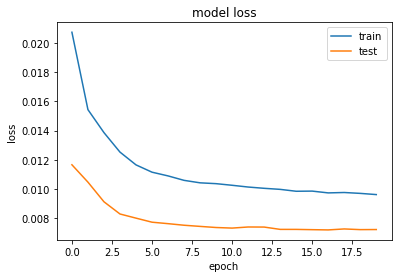

In [61]:
# summarize history for loss
import matplotlib.pyplot as plt
plt.plot(model_summary.history['loss'])
plt.plot(model_summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [62]:
model1 = load_model('model1/')

In [63]:
train_predicted = model1.predict(train_input).flatten()
train_results = pd.DataFrame(data={'train_predicted':train_predicted, 'train_target':train_target.flatten()})

In [64]:
test_predictions = model1.predict(test_input).flatten()
shape = (test_predictions.shape[0],1)
test_predicted = scaler.inverse_transform(np.concatenate((test_predictions.reshape(-1,1),np.ones(shape),np.ones(shape)),axis=1))[:,0]
test_target = scaler.inverse_transform(np.concatenate((test_target.reshape(-1,1),np.ones(shape),np.ones(shape)),axis=1))[:,0]
test_results = pd.DataFrame(data={'test_predicted':test_predicted, 'test_target':test_target})
test_results

,test_predicted,test_target
0,0.750636,0.952567
1,0.888130,1.347467
2,1.455452,1.153667
3,1.389829,0.363700
4,0.727250,0.353500
...,...,...
7964,1.286167,1.725900
7965,1.636598,1.573467
7966,1.534937,1.659333
7967,1.582288,1.163700


In [65]:
np.mean(abs(test_results.test_predicted-test_results.test_target)/test_results.test_target)

0.5442380844615181

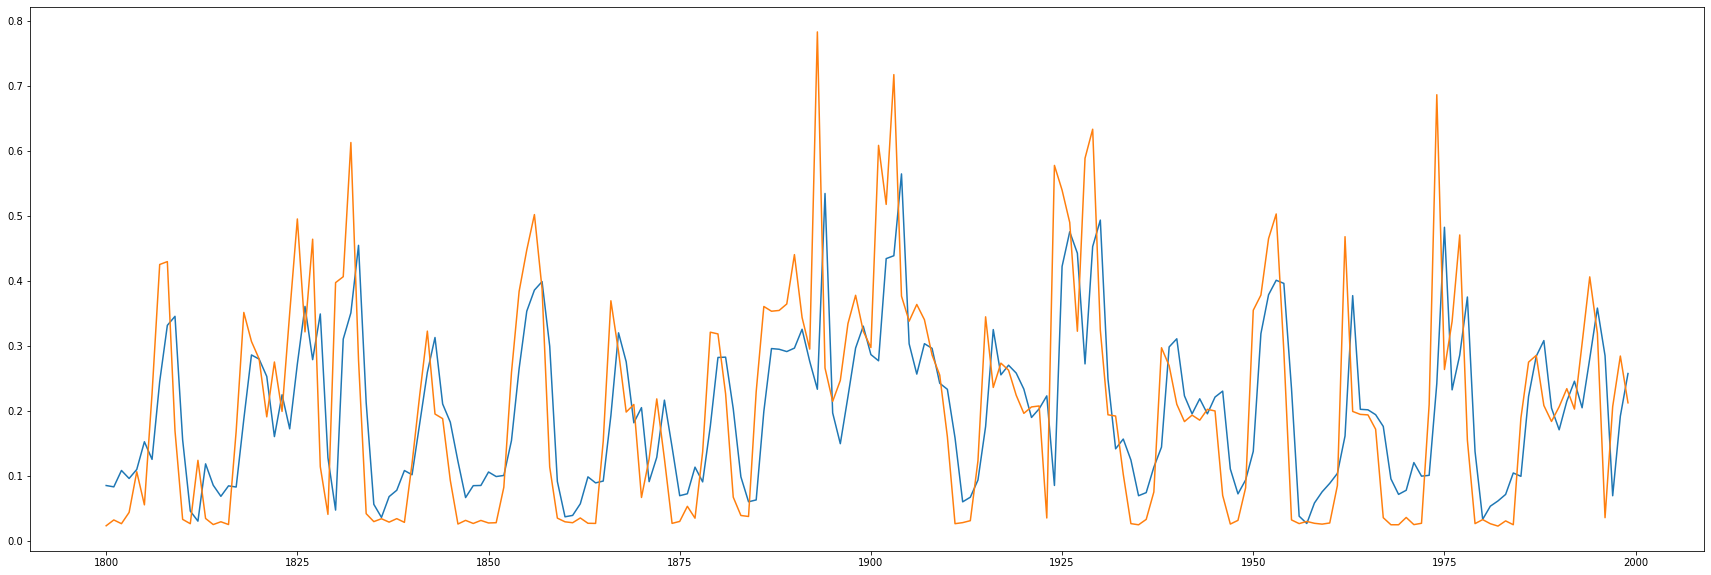

In [67]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.plot(train_results['train_predicted'][1800:2000])
plt.plot(train_results['train_target'][1800:2000])

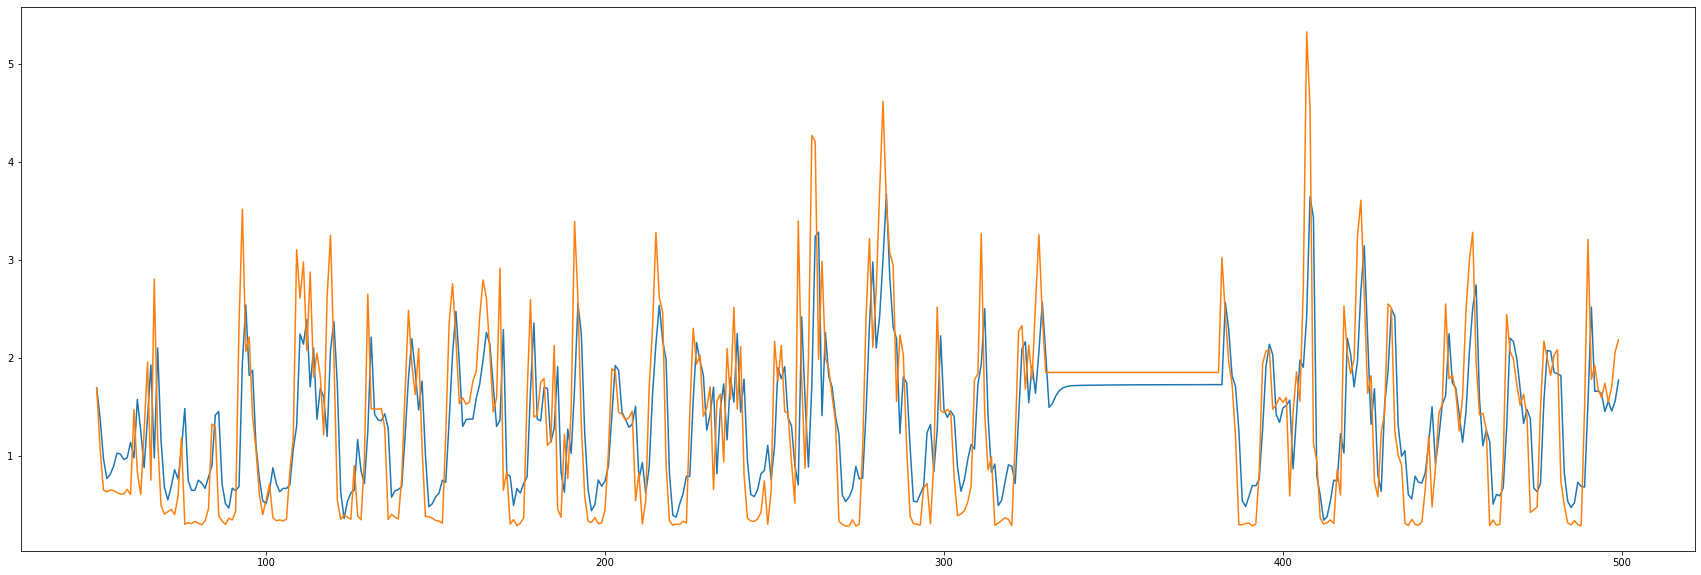

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.plot(test_results['test_predicted'][50:500])
plt.plot(test_results['test_target'][50:500])

**MODEL2..Conv1D**

In [70]:
def create_model():
  model2 = Sequential()
  model2.add(InputLayer((n_lags, len(cols))))
  model2.add(Conv1D(64, kernel_size=2))
  model2.add(Flatten())
  model2.add(Dense(8, 'relu'))
  model2.add(Dense(1, 'linear'))

  model2.summary()
  return model2

In [ ]:
model = create_model()
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model.fit(train_input, train_target, validation_data=(test_input, test_target), epochs=10, callbacks=[cp2])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 119, 64)           448       
                                                                 
 flatten (Flatten)           (None, 7616)              0         
                                                                 
 dense_2 (Dense)             (None, 8)                 60936     
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 61,393
Trainable params: 61,393
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
711/719 [============================>.] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.1020INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


719/719 [==============================] - 5s 7ms/step - loss: 0.0104 - root_mean_squared_error: 0.1017 - val_loss: 1.4237 - val_root_mean_squared_error: 1.1932
Epoch 2/10
711/719 [============================>.] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0931INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


719/719 [==============================] - 5s 7ms/step - loss: 0.0087 - root_mean_squared_error: 0.0931 - val_loss: 1.3871 - val_root_mean_squared_error: 1.1778
Epoch 3/10
719/719 [==============================] - 4s 6ms/step - loss: 0.0084 - root_mean_squared_error: 0.0917 - val_loss: 1.4307 - val_root_mean_squared_error: 1.1961
Epoch 4/10
716/719 [============================>.] - ETA: 0s - loss: 0.0082 - root_mean_squared_error: 0.0903INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


719/719 [==============================] - 5s 7ms/step - loss: 0.0082 - root_mean_squared_error: 0.0903 - val_loss: 1.3628 - val_root_mean_squared_error: 1.1674
Epoch 5/10
719/719 [==============================] - 5s 7ms/step - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 1.3655 - val_root_mean_squared_error: 1.1685
Epoch 6/10
719/719 [==============================] - 4s 6ms/step - loss: 0.0079 - root_mean_squared_error: 0.0891 - val_loss: 1.3928 - val_root_mean_squared_error: 1.1802
Epoch 7/10
719/719 [==============================] - 7s 10ms/step - loss: 0.0078 - root_mean_squared_error: 0.0885 - val_loss: 1.4215 - val_root_mean_squared_error: 1.1923
Epoch 8/10
719/719 [==============================] - 9s 13ms/step - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 1.3793 - val_root_mean_squared_error: 1.1744
Epoch 9/10
719/719 [==============================] - 8s 12ms/step - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 1.3680 - val_root_mea

In [ ]:
from tensorflow.keras.models import load_model
model2 = load_model('model2/')

In [ ]:
train_predicted = model2.predict(train_input).flatten()
train_results = pd.DataFrame(data={'train_predicted':train_predicted, 'train_target':train_target.flatten()})

In [ ]:
test_predictions = model2.predict(test_input).flatten()
test_results = pd.DataFrame(data={'test_predictions':test_predictions, 'test_target':test_target.flatten()})

In [ ]:
print(f"Test error...")
mean_absolute_percentage_error(test_results.test_predictions,test_results.test_target)

In [ ]:
print(f"Training Error....")
mean_absolute_percentage_error(train_results.train_predicted,train_results.train_target)

**Model3...GRU**

In [ ]:
model3 = Sequential()
model3.add(InputLayer((100, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

In [ ]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [ ]:
model3.fit(train_input, train_target, validation_data=(validation_input, validation_target), epochs=10, callbacks=[cp3])

In [ ]:
from tensorflow.keras.models import load_model
model3 = load_model('model3/')

In [ ]:
train_predicted = model2.predict(train_input).flatten()
train_results = pd.DataFrame(data={'train_predicted':train_predicted, 'train_target':train_target.flatten()})

test_predictions = model2.predict(test_input).flatten()
test_results = pd.DataFrame(data={'test_predictions':test_predictions, 'test_target':test_target.flatten()})

In [ ]:
print(f"Test error...")
mean_squared_error(test_results.test_predictions,test_results.test_target)

In [ ]:
print(f"Training Error....")
mean_squared_error(train_results.train_predicted,train_results.train_target)